In [74]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [13]:
# Load the file into dataframe
df = pd.read_csv("shuffle_email_spam_classification.csv")
df.head()

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0


In [14]:
# Check for columns with more than 0 null values
null_columns = df.columns[df.isnull().any()]

# Display columns with null values and their count if any
if (null_columns.size > 0):
    print("Columns with null values:")
    for col in null_columns:
        print(f"{col}: {df[col].isnull().sum()} null values")
else:
    print("There are no columns with null values")

There are no columns with null values


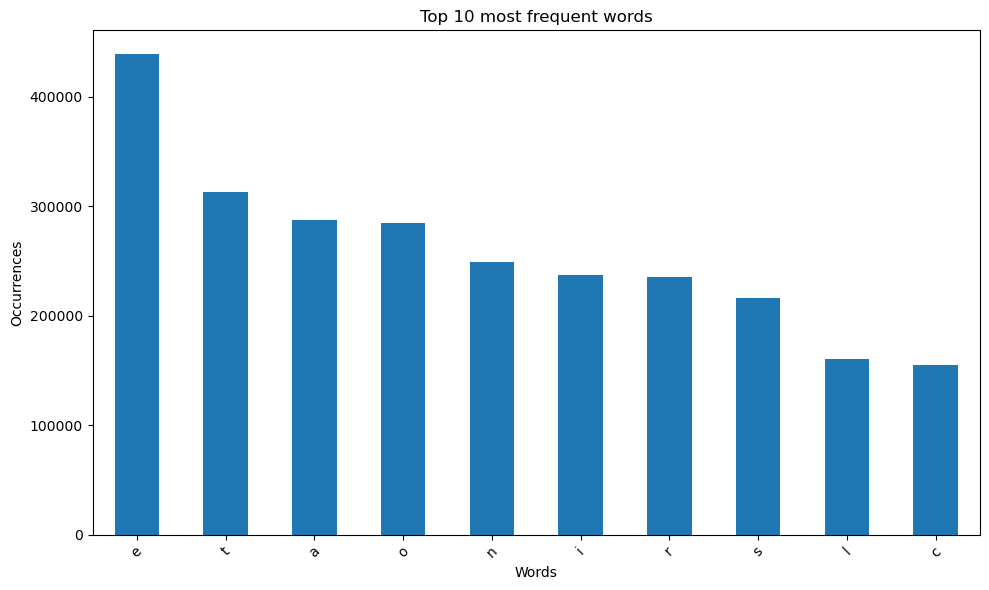

In [15]:
# Sum occurrences of each word. Exclude first and last cols
word_occurrences = df.iloc[:, 1:-1].sum(axis=0)

# Sort words by occurrences
top_words = word_occurrences.sort_values(ascending=False).head(10)

# Plot the top 10 words
plt.figure(figsize=(10, 6))
top_words.plot(kind='bar')
plt.title("Top 10 most frequent words")
plt.xlabel("Words")
plt.ylabel("Occurrences")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

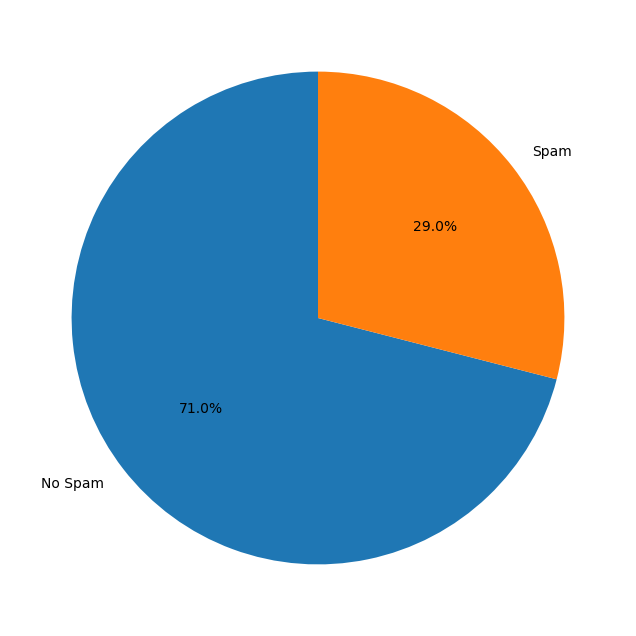

In [16]:
# Create pie chart which shows the percentage of spam emails
spam_counts = df.iloc[:, -1].value_counts()
spam_counts.plot(kind='pie', 
                   labels=spam_counts.index.map({0: 'No Spam', 1: 'Spam'}), 
                   autopct='%1.1f%%', 
                   startangle=90, 
                   figsize=(8, 8))

# Show the plot
plt.ylabel('')  # Remove the y-axis label
plt.show()

In [38]:
# Exclude first and last columns
X = df.iloc[:, 1:-1]

# Remove low-variance columns
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X)

# Get the selected feature names
selected_columns = X.columns[selector.get_support()]

# Create a new DataFrame with reduced features and column names
df_reduced = pd.DataFrame(X_reduced, columns=selected_columns)

In [40]:
df_reduced.head()

,the,to,ect,and,for,of,a,you,hou,in,...,fight,australia,plain,enhancements,connevey,jay,valued,lay,military,ff
0,0,0,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,13,24,6,6,2,102,1,27,18,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,8,0,0,4,...,0,0,0,0,0,0,0,0,0,0
3,0,5,22,0,5,1,51,2,10,1,...,0,0,0,0,0,0,0,0,0,0
4,7,6,17,1,5,2,57,0,9,3,...,0,0,0,0,0,0,0,0,0,1


In [48]:
y = df.iloc[:, -1]

# Select the 500 most important columns
selector = SelectKBest(score_func=f_classif, k=500)
X_selected = selector.fit_transform(df_reduced, y)

# Get selected column names
selected_columns = df_reduced.columns[selector.get_support()]

# Create a new DataFrame with selected features and column names
df_selected = pd.DataFrame(X_selected, columns=selected_columns)

df_selected.head()

,ect,and,of,a,you,hou,in,is,enron,i,...,wild,ward,aren,fire,corel,tm,symbol,plain,valued,ff
0,1,0,0,2,0,0,0,1,0,2,...,0,0,0,0,0,1,0,0,0,0
1,24,6,2,102,1,27,18,13,1,61,...,0,3,3,0,0,0,0,0,0,1
2,1,0,0,8,0,0,4,0,0,8,...,0,0,0,0,0,0,0,0,0,0
3,22,0,1,51,2,10,1,9,0,16,...,0,7,2,0,0,0,0,0,0,0
4,17,1,2,57,0,9,3,2,0,30,...,0,3,1,0,0,0,0,0,0,1


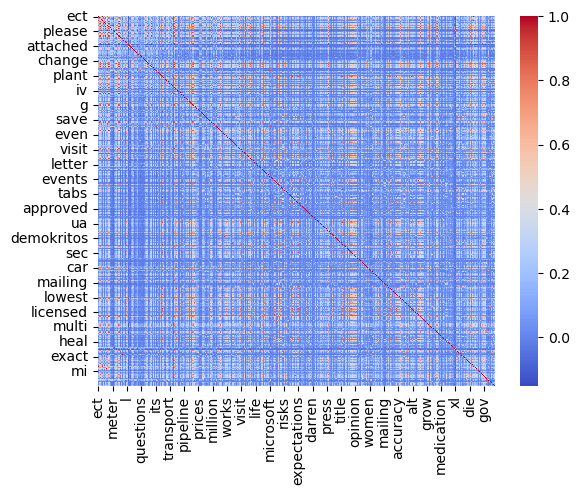

In [50]:
# Calculate and visualize the correlation matrix
correlation_matrix = df_selected.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.show()

In [52]:
# Set a threshold for correlation
threshold = 0.80
to_drop = set()

# Identify highly correlated features
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            to_drop.add(colname)

# Drop the highly correlated features from df_selected
X = df_selected.drop(columns=to_drop)

print(f"Columns dropped due to high correlation: {to_drop}")
X.head()

Columns dropped due to high correlation: {'risks', 'window', 'btu', 'drug', 'form', 'question', 'your', 'assumptions', 'st', 'imited', 'securities', 'apr', 'heal', 'pa', 'o', 'registered', 'l', 'or', 'national', 'materia', 'an', 'expectations', 'n', 'met', 'aren', 'our', 'w', 'is', 'readers', 'duty', 'medication', 'y', 'f', 'valium', 'ad', 'certain', 'nd', 'far', 'em', 'dealer', 'vol', 'la', 'ma', 'congress', 'tr', 'ct', 'hanks', 'xl', 'investor', 'wind', 'hi', 'it', 'photoshop', 'gotten', 'ooking', 'ti', 'follow', 'share', 'subscribers', 'ic', 'ce', 'hp', 'lease', 'internationa', 'format', 'pipe', 'le', 'u', 'ward', 've', 's', 'meaning', 'i', 'a', 'inherent', 're', 'of', 'in', 'company', 'within', 'ur', 'dollar', 'result', 'v', 'un', 'd', 'g', 'materially', 'expect', 'sec', 'invest', 'projections', 'uncertainties', 'htm', 'conflict', 'kin', 'al', 'stocks', 'us', 'state', 'ml', 'register', 'wil', 'p', 'de', 'demokritos', 'r', 'investing', 'statement', 'farmer', 'hou', 'b', 'ca', 'se', 

,ect,and,you,enron,will,with,gas,deal,meter,hpl,...,gov,der,wild,fire,corel,tm,symbol,plain,valued,ff
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,24,6,1,1,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22,0,2,0,0,1,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
4,17,1,0,0,0,0,2,0,3,0,...,0,0,0,0,0,0,0,0,0,1


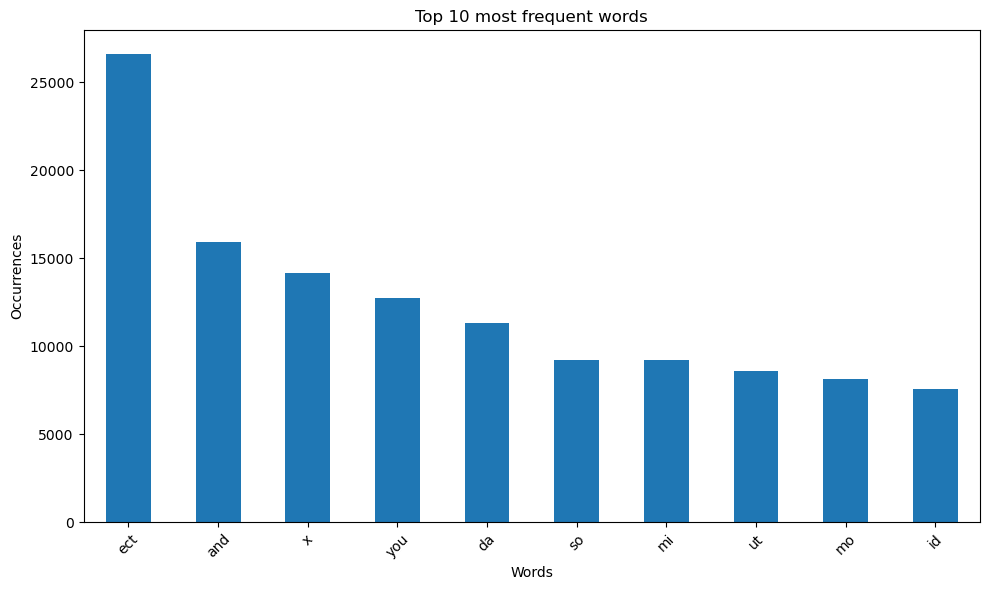

In [54]:
# Sum occurrences of each word. Exclude first and last cols
word_occurrences = X.sum(axis=0)

# Sort words by occurrences
top_words = word_occurrences.sort_values(ascending=False).head(10)

# Plot the top 10 words
plt.figure(figsize=(10, 6))
top_words.plot(kind='bar')
plt.title("Top 10 most frequent words")
plt.xlabel("Words")
plt.ylabel("Occurrences")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [58]:
# Initialize models
rf = RandomForestClassifier(random_state=39)

lgbm = LGBMClassifier(random_state=39, verbose=-1)

In [62]:
# Define a function to calculate all metrics
def calculate_metrics(y_true, y_pred):
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate

    return {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity (Recall)': recall,
        'Specificity': specificity
    }

In [76]:
# Cross-validation setup for Random Forest
kf = StratifiedKFold(n_splits=5)
rf_metrics = []

print("Random Forest Cross-Validation Results:")
for fold, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred)
    metrics['Fold'] = fold  # Add fold number
    rf_metrics.append(metrics)

# Display results for Random Forest
rf_results_df = pd.DataFrame(rf_metrics)
print(rf_results_df)
print("Mean Results for Random Forest:")
print(rf_results_df.mean(numeric_only=True))

Random Forest Cross-Validation Results:
    TP   TN  FP  FN  Accuracy  Precision  Sensitivity (Recall)  Specificity  \
0  286  704  31  14  0.956522   0.902208              0.953333     0.957823   
1  281  723  12  19  0.970048   0.959044              0.936667     0.983673   
2  274  719  15  26  0.960348   0.948097              0.913333     0.979564   
3  286  715  19  14  0.968085   0.937705              0.953333     0.974114   
4  277  693  41  23  0.938104   0.871069              0.923333     0.944142   

   Fold  
0     1  
1     2  
2     3  
3     4  
4     5  
Mean Results for Random Forest:
TP                      280.800000
TN                      710.800000
FP                       23.600000
FN                       19.200000
Accuracy                  0.958622
Precision                 0.923625
Sensitivity (Recall)      0.936000
Specificity               0.967863
Fold                      3.000000
dtype: float64


In [78]:
# Cross-validation setup for LGBM
kf = StratifiedKFold(n_splits=5)
lgbm_metrics = []

print("\nLGBM Cross-Validation Results:")
for fold, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred)
    metrics['Fold'] = fold  # Add fold number
    lgbm_metrics.append(metrics)

# Display results for lgbm
lgbm_results_df = pd.DataFrame(lgbm_metrics)
print(lgbm_results_df)
print("Mean Results for LGBM:")
print(lgbm_results_df.mean(numeric_only=True))


LGBM Cross-Validation Results:
    TP   TN  FP  FN  Accuracy  Precision  Sensitivity (Recall)  Specificity  \
0  287  703  32  13  0.956522   0.899687              0.956667     0.956463   
1  281  724  11  19  0.971014   0.962329              0.936667     0.985034   
2  284  719  15  16  0.970019   0.949833              0.946667     0.979564   
3  286  714  20  14  0.967118   0.934641              0.953333     0.972752   
4  280  694  40  20  0.941973   0.875000              0.933333     0.945504   

   Fold  
0     1  
1     2  
2     3  
3     4  
4     5  
Mean Results for LGBM:
TP                      283.600000
TN                      710.800000
FP                       23.600000
FN                       16.400000
Accuracy                  0.961329
Precision                 0.924298
Sensitivity (Recall)      0.945333
Specificity               0.967863
Fold                      3.000000
dtype: float64


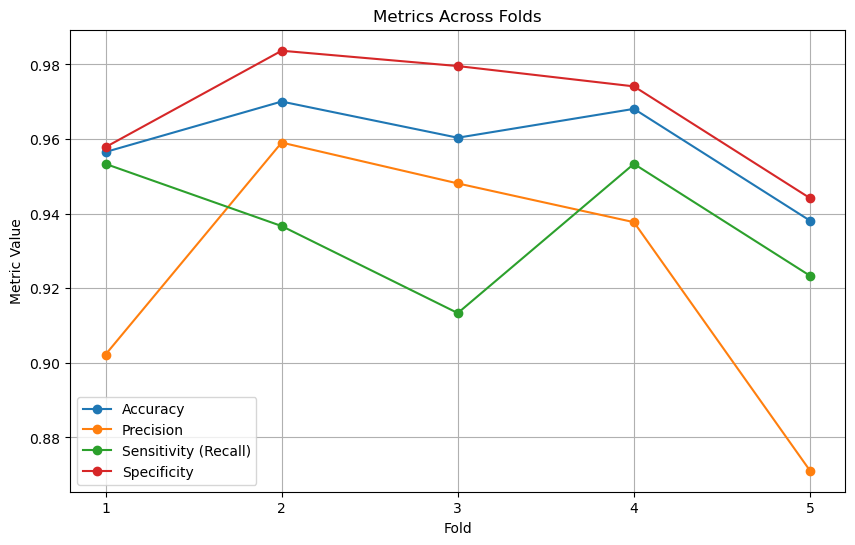

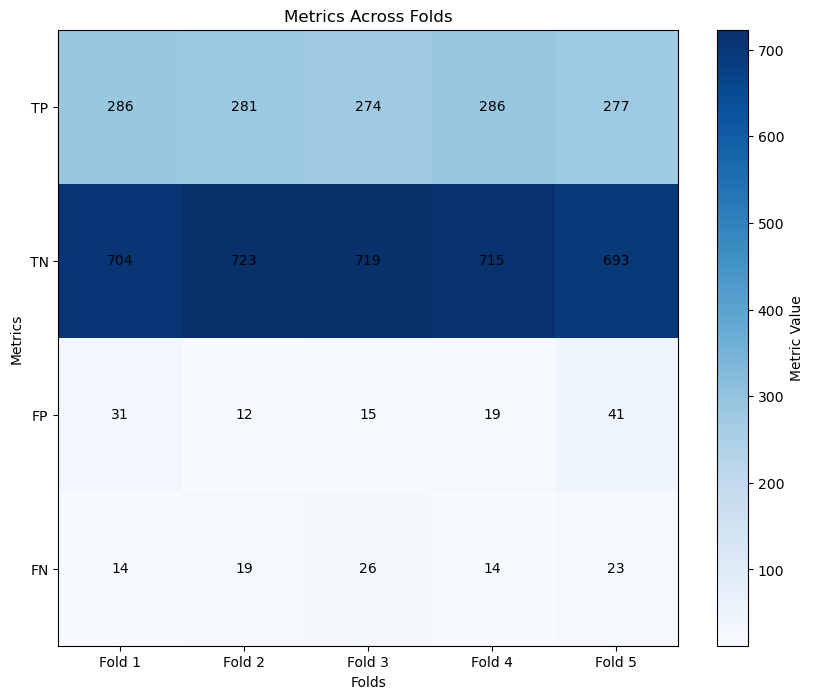

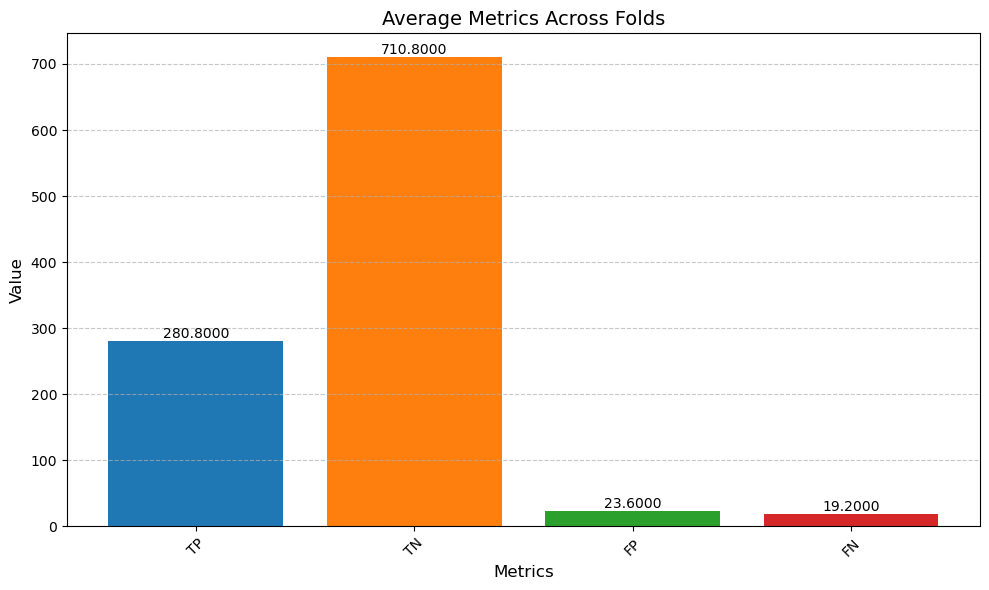

In [84]:
# plotting_df = lgbm_results_df
plotting_df = rf_results_df

# 1. Line Plot for all metrics across folds
metrics_labels = ['Accuracy', 'Precision', 'Sensitivity (Recall)', 'Specificity']

plt.figure(figsize=(10, 6))
for metric in metrics_labels:
    plt.plot(plotting_df['Fold'], plotting_df[metric], marker='o', label=metric)
plt.title('Metrics Across Folds')
plt.xlabel('Fold')
plt.ylabel('Metric Value')
plt.xticks(plotting_df['Fold'])
plt.legend()
plt.grid()
plt.show()

# 2. # Extract metrics as rows and folds as columns
alarms = ['TP', 'TN', 'FP', 'FN']
metrics_df = plotting_df[alarms].T  # Transpose to have metrics as rows and folds as columns
metrics_df.columns = [f'Fold {fold}' for fold in plotting_df['Fold']]

# Plot a heatmap for metrics vs folds
plt.figure(figsize=(10, 8))
plt.imshow(metrics_df, cmap='Blues', aspect='auto', interpolation='nearest')
plt.colorbar(label='Metric Value')
plt.title('Metrics Across Folds')
plt.xlabel('Folds')
plt.ylabel('Metrics')
plt.xticks(range(len(metrics_df.columns)), metrics_df.columns)
plt.yticks(range(len(metrics_df.index)), metrics_df.index)

# Add values on the heatmap
for i in range(len(metrics_df.index)):
    for j in range(len(metrics_df.columns)):
        plt.text(j, i, f'{metrics_df.iloc[i, j]:.4f}' if metrics_df.index[i] not in ['TP', 'TN', 'FP', 'FN'] else f'{int(metrics_df.iloc[i, j])}',
                 ha='center', va='center', color='black')

plt.show()

# 3. Average Bar Plot for each metric
avg_metrics = plotting_df[alarms].mean()

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(
    avg_metrics.index,  # Metric names
    avg_metrics.values,  # Average values
    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'],  # Custom colors
)

# Add value annotations above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Horizontal position
        yval,  # Vertical position
        f'{yval:.4f}',  # Format the value
        ha='center', va='bottom', fontsize=10  # Center alignment
    )

# Add title, labels, and grid lines
plt.title('Average Metrics Across Folds', fontsize=14)
plt.ylabel('Value', fontsize=12)
plt.xlabel('Metrics', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()